In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Perceptron:
    def __init__(
        self,
        input_size,
        num_classes,
        activation_function,
        activation_function_derivative,
        learning_rate=0.01,
        epochs=1000
    ):
        """
        Инициализация персептрона
        :param input_size: количество входов (размерность входных данных)
        :param num_classes: количество классов для классификации
        :param learning_rate: скорость обучения
        :param epochs: количество итераций обучения
        :param activation_function: функция активации
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = np.zeros((num_classes, input_size + 1))  # Веса для каждого класса + 1 для смещения (bias)
        self.activation_function = lambda x: list(map(activation_function, x))
        self.activation_function_derivative = lambda x: list(map(activation_function_derivative, x))
        self.mse = lambda target, output: (output - target) ** 2 / len(target)
        self.mse_derivative = lambda target, output: 2 * (output - target) / len(target)

    def softmax(self, x):
        """
        Softmax для получения вероятностей
        :param x: входной вектор
        :return: вектор вероятностей
        """
        exp_x = np.exp(x - np.max(x))  # Для стабильности вычислений вычитаем максимум
        return exp_x / exp_x.sum(axis=0)

    def predict(self, X):
        """
        Прогноз на основе текущих весов
        :param X: Входные данные (без смещения)
        :return: Вектор вероятностей для каждого класса
        """
        linear_output = np.dot(self.weights[:, 1:], X) + self.weights[:, 0]
        return self.softmax(self.activation_function(linear_output))

    def fit(self, X, y):
        """
        Обучение персептрона с использованием MSE
        :param X: Массив входных данных, размерность (n_samples, input_size)
        :param y: Целевые метки (n_samples,) в формате индексов классов
        """
        for epoch in range(self.epochs):
            for i in range(len(X)):
                # Прямой проход: получаем прогноз (вероятности)
                probabilities = self.predict(X[i])
                # Преобразуем целевую метку в one-hot вектор
                target = np.zeros(len(probabilities))
                target[y[i]] = 1
                # Вычисляем производную MSE по выходу
                mse_grad = self.mse_derivative(target, probabilities)
                # Вычисляем градиент активационной функции
                activation_grad = self.activation_function_derivative(np.dot(self.weights[:, 1:], X[i]) + self.weights[:, 0])
                # Общий градиент
                gradient = mse_grad * activation_grad
                # Обновляем веса для каждого класса
                self.weights[:, 1:] -= self.learning_rate * np.outer(gradient, X[i])
                self.weights[:, 0] -= self.learning_rate * gradient  # Обновляем смещение (bias)

    def evaluate(self, X, y):
        """
        Оценка точности модели на тестовых данных
        :param X: Входные данные
        :param y: Истинные метки
        :return: Точность модели
        """
        correct_predictions = 0
        for i in range(len(X)):
            probabilities = self.predict(X[i])
            prediction = np.argmax(probabilities)
            if prediction == y[i]:
                correct_predictions += 1
        return correct_predictions / len(X)
    

    def evaluate_mse(self, X, y):
        """
        Оценка точности модели на тестовых данных по функции потерь
        :param X: Входные данные
        :param y: Истинные метки
        :return: Среднее значение функции потерь MSE
        """
        mse_accuracy = 0
        for i in range(len(X)):
            probabilities = self.predict(X[i])
            target = np.zeros(len(probabilities))
            target[y[i]] = 1
            mse_accuracy += self.mse(target, probabilities).sum()
        return mse_accuracy / len(X)

In [3]:
def find_min_epochs_count(
    X, y,
    max_epochs,
    activation_function,
    activation_function_derivative,
    activation_name,
    return_mse_accuracy=False
):
    input_size = len(X[0])
    num_classes = max(y) + 1
    accuracies = []
    epoch_list = []

    for epochs in range(1, max_epochs + 1):
        perceptron = Perceptron(
            input_size=input_size,
            num_classes=num_classes,
            activation_function=activation_function,
            activation_function_derivative=activation_function_derivative,
            learning_rate=0.01,
            epochs=epochs,
        )
        perceptron.fit(X, y)
        if return_mse_accuracy:
            accuracy = perceptron.evaluate_mse(X, y)
        else:
            accuracy = perceptron.evaluate(X, y)

        accuracies.append(accuracy)
        epoch_list.append(epochs)

    plt.plot(epoch_list, accuracies, marker=".", label=activation_name)

    max_accurace_i = np.argmax(accuracies)
    return epoch_list[max_accurace_i], accuracies[max_accurace_i]

In [4]:
data = json.load(open("data.json"))

keys = {key: i for i, key in enumerate(set(next(zip(*data))))}
alphabet = {key: i for i, key in keys.items()}
X = np.array([
        [
            (1 if draw_cell == "#" else 0)
            for draw_cell in ''.join(draw)
        ] for _, draw in data
    ])
y = np.array([keys[key] for key, _ in data])

Линейная функция активации: (19, 1.0)
ReLu: (17, 1.0)
Сигмоида: (23, 0.9743589743589743)
Гиперболический тангенс: (17, 0.9743589743589743)


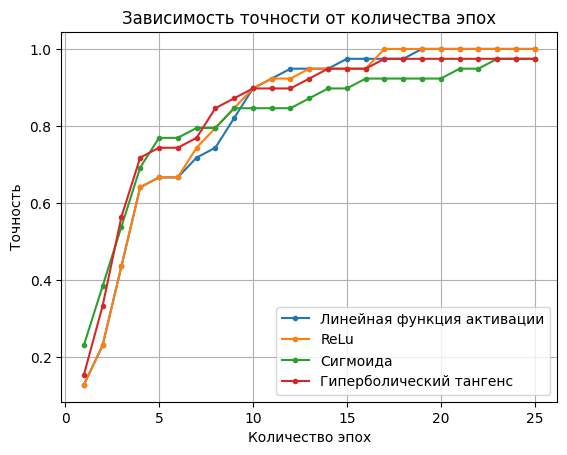

In [5]:
EPOCHS = 25

k = 9
print("Линейная функция активации:", find_min_epochs_count(
    X, y, EPOCHS,
    activation_function=lambda x:
        (lambda x, k: k * x)(x, k=k),
    activation_function_derivative=lambda x: k,
    activation_name="Линейная функция активации"
))

k = 10
print("ReLu:", find_min_epochs_count(
    X, y, EPOCHS,
    activation_function=lambda x:
        (lambda x, k: k * x if x > 0 else 0)(x, k=k),
    activation_function_derivative=lambda x: k,
    activation_name="ReLu"
))

sigmoida = lambda x, k: 1 / (1 + np.exp(-k * x))
sigmoida_derivative = lambda x, k: k * sigmoida(x, k) * (1 - sigmoida(x, k))
k = 24
print("Сигмоида:", find_min_epochs_count(
    X, y, EPOCHS,
    activation_function=lambda x: sigmoida(x, k=k),
    activation_function_derivative=lambda x: sigmoida_derivative(x, k=k),
    activation_name="Сигмоида"
))

tanh_derivative = lambda x, k: k * (1 - np.tanh(k * x) ** 2)
k = 8
print("Гиперболический тангенс:", find_min_epochs_count(
    X, y, EPOCHS,
    activation_function=lambda x: np.tanh(k * x),
    activation_function_derivative=lambda x: tanh_derivative(x, k=k),
    activation_name="Гиперболический тангенс"
))

plt.title("Зависимость точности от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.grid(True)
plt.legend()
plt.show()

Линейная функция активации: (1, 0.05976357070354698)
ReLu: (1, 0.0592731070232246)
Сигмоида: (1, 0.06046206089182869)
Гиперболический тангенс: (1, 0.05918657292960894)


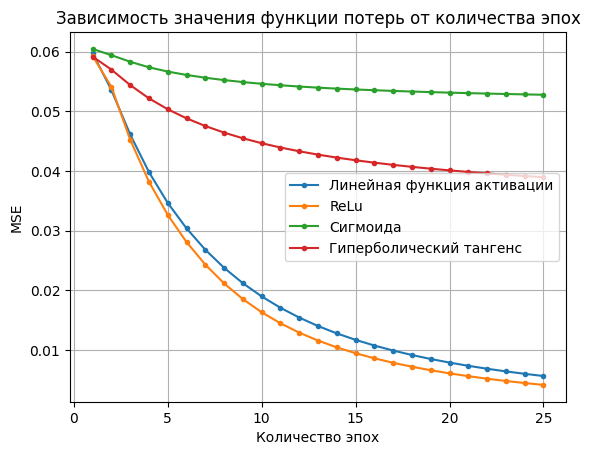

In [6]:
EPOCHS = 25

k = 9
print("Линейная функция активации:", find_min_epochs_count(
    X, y, EPOCHS,
    activation_function=lambda x:
        (lambda x, k: k * x)(x, k=k),
    activation_function_derivative=lambda x: k,
    activation_name="Линейная функция активации",
    return_mse_accuracy=True,
))

k = 10
print("ReLu:", find_min_epochs_count(
    X, y, EPOCHS,
    activation_function=lambda x:
        (lambda x, k: k * x if x > 0 else 0)(x, k=k),
    activation_function_derivative=lambda x: k,
    activation_name="ReLu",
    return_mse_accuracy=True,
))

sigmoida = lambda x, k: 1 / (1 + np.exp(-k * x))
sigmoida_derivative = lambda x, k: k * sigmoida(x, k) * (1 - sigmoida(x, k))
k = 24
print("Сигмоида:", find_min_epochs_count(
    X, y, EPOCHS,
    activation_function=lambda x: sigmoida(x, k=k),
    activation_function_derivative=lambda x: sigmoida_derivative(x, k=k),
    activation_name="Сигмоида",
    return_mse_accuracy=True,
))

tanh_derivative = lambda x, k: k * (1 - np.tanh(k * x) ** 2)
k = 8
print("Гиперболический тангенс:", find_min_epochs_count(
    X, y, EPOCHS,
    activation_function=lambda x: np.tanh(k * x),
    activation_function_derivative=lambda x: tanh_derivative(x, k=k),
    activation_name="Гиперболический тангенс",
    return_mse_accuracy=True,
))

plt.title("Зависимость значения функции потерь от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()